In [111]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, scale, minmax_scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression

In [34]:
def create_data(data_X, data_Y, number_X, number_Y):
    '''
    Basic idea:
    create several sub-dataframes and concat them together.
    For instance:
    Samples : 1,2,3,4,5,6,7
    number X = 3
    number Y = 2
    
    for measurements, create data frames:
    1    |    2    |    3
    2    |    3    |    4
    3    |    4    |    5
    
    Then concat them together, we can get 3 new sample measurements:
    
    Sample 1: 1, 2, 3
    Sample 2: 2, 3, 4
    Sample 3: 3, 4, 5
    '''
    
    # to get the coloumn names
    features_name = [col for col in data_X]
    target_name = [col for col in data_Y]
    X_shape = data_X.shape
    index_X = data_X.index
    number_samples = X_shape[0]
    
    number_to_delete = number_X + number_Y -1
    number_measurements = number_samples - number_to_delete
    temp_X = []
    rst_df = None
    rst_index = None
    # create number_X dataframes and concat them together
    # for each dataframe, we should delete number_X -1 entries
    # create the delete lish
    for i in range(number_X):
        data_copy = data_X.copy()
        '''
        del_list contains the index of samples which should be deleted for each sub-dataframes
        '''
        del_list = []
        
        for j in range(i):
            del_list.append(index_X[j])
        for k in range(number_to_delete - i):
            del_list.append(index_X[number_samples - k -1])
        if i == 0:
            # the first sub-dataframe, create it directly
            rst_df = data_copy.drop(del_list, axis=0)
            rst_df.columns = [j+str(i) for j in features_name]
            rst_index = rst_df.index
        else:
            # concat the new sub-dataframe with the previous result
#             print(del_list)
            temp_df = data_copy.drop(del_list, axis=0)
            temp_df.index = rst_index
            temp_df.columns = [j+str(i) for j in features_name]
            rst_df = pd.concat([rst_df, temp_df], axis=1)
#             print(rst_df.shape)
            
    for i in range(number_Y):
        target_copy = data_Y.copy()
        del_list = []
        for j in range(number_X + i):
            del_list.append(index_X[j])
        for k in range(number_Y -1 - i):
            del_list.append(index_X[number_samples - k -1])
#         print(del_list)
        if i == 0:
            tgt_df = target_copy.drop(del_list, axis=0)
            tgt_df.columns = [j+str(i) for j in target_name]
            tgt_index = tgt_df.index
        else:
#             print(del_list)
            temp_df = target_copy.drop(del_list, axis=0)
            temp_df.index = tgt_index
            temp_df.columns = [j+str(i) for j in target_name]
            tgt_df = pd.concat([tgt_df, temp_df], axis=1)
            print(tgt_df.shape)
    return rst_df, tgt_df

In [88]:
# input data should be np array, only outliers in X will be considered
def OutlierRemoval(InputX, InputY, Threhold):
    
    Y_FeatureColumn = [i for i in range(len(InputX[0]), len(InputX[0]) + len(InputY[0]))]
    
    # combine X and Y
    combine_data = np.c_[InputX, InputY]
    
    # remove outlier in X
    removed_data = combine_data[np.all(np.abs(np.delete(combine_data, Y_FeatureColumn, 1)) < Threhold ,axis=1)]
    
    # spilit removed_data into X and Y
    removed_x = np.delete(removed_data, Y_FeatureColumn, 1)
    removed_y = removed_data[:,Y_FeatureColumn]
    
    return removed_x, removed_y

# All input data should be np array
def CalculateNMAE(PredictData, TestData):
    return mean_absolute_error(PredictData, TestData)/TestData.mean()


# feature selection, only return X since we don't change Y
def TreeBasedSelection(InputX, InputY, FeatureNumber):
    # create and fit selector
    clf = ExtraTreesRegressor()
    clf = clf.fit(InputX, InputY)
    
    # only number of sorted features will be selected, and we disable threshold
    model = SelectFromModel(clf, prefit=True, max_features = FeatureNumber, threshold=-np.inf)
    OutputX = model.transform(InputX)
    return OutputX

# standardize column value
def ColumnStandardize(Input):
    Scaler = StandardScaler()
    return Scaler.fit_transform(Input)

In [296]:
'''
To defince the dataset we use
'''
# fileName_X = './VoD_Periodic_2017/X.csv'
# fileName_Y = './VoD_Periodic_2017/Y.csv'
fileName_X = './KV_flash/X.csv'
fileName_Y = './KV_flash/Y.csv'
# fileName_X = './KV_flash/VOD_X.csv'
# fileName_Y = './KV_flash/VOD_Y.csv'
# fileName_X = '../X.csv'
# fileName_Y = '../Y.csv'
# fileName_X = './VoD_flash/X.csv'
# fileName_Y = './VoD_flash/Y.csv'

In [297]:
'''
Read data from csv file.
X and Y are raw data
Y_notime and Y_notime are data without timestamp
X_features are a list which contains the name of all of the features in X
'''
X = pd.read_csv(fileName_X)
Y = pd.read_csv(fileName_Y)[['TimeStamp', 'WritesAvg']]
# Y = pd.read_csv(fileName_Y)[['TimeStamp', 'DispFrames']]
X_notime = X.drop('TimeStamp',axis=1)
Y_notime = Y.drop(['TimeStamp'],axis=1)
timeIndex_x=pd.to_datetime(X['TimeStamp'])
timeIndex_y=pd.to_datetime(Y['TimeStamp'])
X.index=timeIndex_x
Y.index=timeIndex_y
X_notime.index = timeIndex_x
Y_notime.index = timeIndex_y
X_features = [col for col in X_notime]
np.random.seed(0)

In [298]:
# change from dataframe to np array
X_npArray = X_notime.to_numpy()
Y_npArray = Y_notime.to_numpy()

# standardize the data
X_Standard = ColumnStandardize(X_npArray)

# remove outlier with threshold 100
X_NoOutlier, Y_NoOutlier = OutlierRemoval(X_Standard, Y_npArray, 100)

# tree based feature selection and have only 16 features
X_FeatureSelection = TreeBasedSelection(X_NoOutlier, Y_NoOutlier, 16)

/home/chen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [299]:
# change X from np array back to dataframe

feature_name = []
for i in range(16):
    feature_name.append('feature'+str(i+1))
    
X_BackToDF = pd.DataFrame(data = X_FeatureSelection,  columns=feature_name)

Y_BackToDF = pd.DataFrame(data = Y_NoOutlier,  columns=Y_notime.columns)

In [300]:
# train set split and sort by index

X_train, X_test, Y_train, Y_test = train_test_split(X_BackToDF, Y_BackToDF, test_size=0.3, random_state=1)
X_train = X_train.sort_index(axis = 0)
X_test = X_test.sort_index(axis = 0)
Y_train = Y_train.sort_index(axis = 0)
Y_test = Y_test.sort_index(axis = 0)

In [301]:
Regressor = LinearRegression()
NMAE_table = []

for h in range(1, 12):
    temp_list = []
    print(NMAE_table)
    for l in range(1, 12):
        xtrain, ytrain = create_data(X_train, Y_train, l, h)
        xtest, ytest = create_data(X_test, Y_test, l, h)
        Linear.fit(xtrain, ytrain)
        pred = Linear.predict(xtest)
        temp_list.append(round(CalculateNMAE(pred, ytest)[0], 4))
    NMAE_table.append(temp_list)

[]
[[0.0242, 0.024, 0.0239, 0.024, 0.024, 0.024, 0.024, 0.024, 0.0241, 0.0241, 0.0241]]
(13552, 2)
(5808, 2)
(13551, 2)
(5807, 2)
(13550, 2)
(5806, 2)
(13549, 2)
(5805, 2)
(13548, 2)
(5804, 2)
(13547, 2)
(5803, 2)
(13546, 2)
(5802, 2)
(13545, 2)
(5801, 2)
(13544, 2)
(5800, 2)
(13543, 2)
(5799, 2)
(13542, 2)
(5798, 2)
[[0.0242, 0.024, 0.0239, 0.024, 0.024, 0.024, 0.024, 0.024, 0.0241, 0.0241, 0.0241], [0.0248, 0.0247, 0.0247, 0.0247, 0.0248, 0.0248, 0.0248, 0.0248, 0.0249, 0.0249, 0.0249]]
(13551, 2)
(13551, 3)
(5807, 2)
(5807, 3)
(13550, 2)
(13550, 3)
(5806, 2)
(5806, 3)
(13549, 2)
(13549, 3)
(5805, 2)
(5805, 3)
(13548, 2)
(13548, 3)
(5804, 2)
(5804, 3)
(13547, 2)
(13547, 3)
(5803, 2)
(5803, 3)
(13546, 2)
(13546, 3)
(5802, 2)
(5802, 3)
(13545, 2)
(13545, 3)
(5801, 2)
(5801, 3)
(13544, 2)
(13544, 3)
(5800, 2)
(5800, 3)
(13543, 2)
(13543, 3)
(5799, 2)
(5799, 3)
(13542, 2)
(13542, 3)
(5798, 2)
(5798, 3)
(13541, 2)
(13541, 3)
(5797, 2)
(5797, 3)
[[0.0242, 0.024, 0.0239, 0.024, 0.024, 0.024

(13540, 2)
(13540, 3)
(13540, 4)
(13540, 5)
(13540, 6)
(13540, 7)
(13540, 8)
(5796, 2)
(5796, 3)
(5796, 4)
(5796, 5)
(5796, 6)
(5796, 7)
(5796, 8)
(13539, 2)
(13539, 3)
(13539, 4)
(13539, 5)
(13539, 6)
(13539, 7)
(13539, 8)
(5795, 2)
(5795, 3)
(5795, 4)
(5795, 5)
(5795, 6)
(5795, 7)
(5795, 8)
(13538, 2)
(13538, 3)
(13538, 4)
(13538, 5)
(13538, 6)
(13538, 7)
(13538, 8)
(5794, 2)
(5794, 3)
(5794, 4)
(5794, 5)
(5794, 6)
(5794, 7)
(5794, 8)
(13537, 2)
(13537, 3)
(13537, 4)
(13537, 5)
(13537, 6)
(13537, 7)
(13537, 8)
(5793, 2)
(5793, 3)
(5793, 4)
(5793, 5)
(5793, 6)
(5793, 7)
(5793, 8)
(13536, 2)
(13536, 3)
(13536, 4)
(13536, 5)
(13536, 6)
(13536, 7)
(13536, 8)
(5792, 2)
(5792, 3)
(5792, 4)
(5792, 5)
(5792, 6)
(5792, 7)
(5792, 8)
[[0.0242, 0.024, 0.0239, 0.024, 0.024, 0.024, 0.024, 0.024, 0.0241, 0.0241, 0.0241], [0.0248, 0.0247, 0.0247, 0.0247, 0.0248, 0.0248, 0.0248, 0.0248, 0.0249, 0.0249, 0.0249], [0.0256, 0.0255, 0.0255, 0.0255, 0.0256, 0.0256, 0.0256, 0.0256, 0.0257, 0.0257, 0.0257], 

(13537, 2)
(13537, 3)
(13537, 4)
(13537, 5)
(13537, 6)
(13537, 7)
(13537, 8)
(13537, 9)
(13537, 10)
(13537, 11)
(5793, 2)
(5793, 3)
(5793, 4)
(5793, 5)
(5793, 6)
(5793, 7)
(5793, 8)
(5793, 9)
(5793, 10)
(5793, 11)
(13536, 2)
(13536, 3)
(13536, 4)
(13536, 5)
(13536, 6)
(13536, 7)
(13536, 8)
(13536, 9)
(13536, 10)
(13536, 11)
(5792, 2)
(5792, 3)
(5792, 4)
(5792, 5)
(5792, 6)
(5792, 7)
(5792, 8)
(5792, 9)
(5792, 10)
(5792, 11)
(13535, 2)
(13535, 3)
(13535, 4)
(13535, 5)
(13535, 6)
(13535, 7)
(13535, 8)
(13535, 9)
(13535, 10)
(13535, 11)
(5791, 2)
(5791, 3)
(5791, 4)
(5791, 5)
(5791, 6)
(5791, 7)
(5791, 8)
(5791, 9)
(5791, 10)
(5791, 11)
(13534, 2)
(13534, 3)
(13534, 4)
(13534, 5)
(13534, 6)
(13534, 7)
(13534, 8)
(13534, 9)
(13534, 10)
(13534, 11)
(5790, 2)
(5790, 3)
(5790, 4)
(5790, 5)
(5790, 6)
(5790, 7)
(5790, 8)
(5790, 9)
(5790, 10)
(5790, 11)
(13533, 2)
(13533, 3)
(13533, 4)
(13533, 5)
(13533, 6)
(13533, 7)
(13533, 8)
(13533, 9)
(13533, 10)
(13533, 11)
(5789, 2)
(5789, 3)
(5789, 4)
(5

In [302]:
NMAE_table

[[0.0242,
  0.024,
  0.0239,
  0.024,
  0.024,
  0.024,
  0.024,
  0.024,
  0.0241,
  0.0241,
  0.0241],
 [0.0248,
  0.0247,
  0.0247,
  0.0247,
  0.0248,
  0.0248,
  0.0248,
  0.0248,
  0.0249,
  0.0249,
  0.0249],
 [0.0256,
  0.0255,
  0.0255,
  0.0255,
  0.0256,
  0.0256,
  0.0256,
  0.0256,
  0.0257,
  0.0257,
  0.0257],
 [0.0262,
  0.0261,
  0.0261,
  0.0262,
  0.0262,
  0.0263,
  0.0263,
  0.0263,
  0.0263,
  0.0263,
  0.0263],
 [0.0268,
  0.0267,
  0.0267,
  0.0268,
  0.0269,
  0.0269,
  0.0269,
  0.0269,
  0.0269,
  0.0269,
  0.027],
 [0.0273,
  0.0273,
  0.0273,
  0.0273,
  0.0274,
  0.0274,
  0.0275,
  0.0275,
  0.0275,
  0.0275,
  0.0275],
 [0.0278,
  0.0278,
  0.0278,
  0.0278,
  0.0279,
  0.0279,
  0.028,
  0.028,
  0.028,
  0.028,
  0.028],
 [0.0283,
  0.0282,
  0.0283,
  0.0283,
  0.0284,
  0.0284,
  0.0284,
  0.0284,
  0.0284,
  0.0284,
  0.0285],
 [0.0288,
  0.0287,
  0.0287,
  0.0288,
  0.0288,
  0.0288,
  0.0289,
  0.0289,
  0.0289,
  0.0289,
  0.0289],
 [0.0292,
  0

In [303]:
y_naive = pd.DataFrame({'result':[Y_train.mean()]*len(Y_test)})

In [304]:
CalculateNMAE(y_naive, Y_test)

WritesAvg    0.041062
dtype: float64

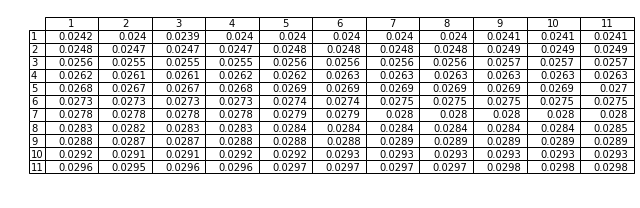

In [305]:
ColLable = [i for i in range(1, 12)]
RowLable = [i for i in range(1, 12)]
fig, ax = plt.subplots(figsize=(9, 3))
ax.axis('off')
ax.axis('tight')

ax.table(cellText=NMAE_table, rowLabels= RowLable, colLabels = ColLable, loc='center')
fig.tight_layout()
plt.show()

In [195]:
xtrain, ytrain = create_data(X_train, Y_train, 1, 1)
xtest, ytest = create_data(X_test, Y_test, 1, 1)
Linear = LinearRegression()
Linear.fit(xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [196]:
pred = Linear.predict(xtest)

In [197]:
# print(CalculateNMAE(pred[:,1], ytest['WritesAvg1']))
print(CalculateNMAE(pred[:,0], ytest['WritesAvg0']))
print(CalculateNMAE(pred, ytest))

0.024153412894430955
WritesAvg0    0.024153
dtype: float64


In [99]:
'''
Data Information
'''

X_shape = X_notime.shape
print("X_shape is " + str(X_shape))

X_shape is (3600, 12)


In [110]:
for i in range(3):
#     target_copy = data_Y.copy()
    del_list = []
    for j in range(3 + i):
        del_list.append(j)
    for k in range(3 -1 - i):
        del_list.append(10 - k -1)
    print(del_list)

[0, 1, 2, 9, 8]
[0, 1, 2, 3, 9]
[0, 1, 2, 3, 4]
